# Model the short term outcomes for stroke patients

## Table of contents

+ [Notebook setup](#notebook-setup)
+ [Preprocessing]((#preprocessing))
    + [The target](#the-target)
    + [The features](#the-features)
    + [Splitting the dataset](#splitting-the-dataset)
    + [Imbalances](#imbalances)
    + [Preparation of Data Scaling and Category Encoding](#preparation-of-data-scaling-and-category-encoding)
    [The metric](#the-metric)
+ [Dummy Classifier](#dummy-classifier)
+ [Logistic Regression](#logistic-regression)
    + Standard Scaler
    + MinMaxScaler
+ [Decision Tree](#decision-tree)
+ [Random Forest](#random-forest)
+ [Extra Tree](#random-forest)
+ [XGBoost](#xgboost)
+ [Support Vector Machines](#support-vector-machines)

-----

## Notebook setup

In [22]:
# general
import pandas as pd
import numpy as np

from functions import helper

# plot libarys
import seaborn as sns
import matplotlib.pyplot as plt


# Model preparation
#import imblearn
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
 

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz  
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.dummy import DummyClassifier

# Model Metrics
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, plot_confusion_matrix
from scipy.stats import multivariate_normal, sem

# for merging the dataframes
import os, glob
import json

# further libarys
#import itertools
from sklearn.tree import export_graphviz
from collections import Counter

%matplotlib inline

In [3]:
# get the data
df = pd.read_csv('data/IST_corrected_clean.csv',  index_col= [0])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18779 entries, 0 to 19434
Columns: 113 entries, HOSPNUM to RDISCH14
dtypes: float64(16), int64(29), object(68)
memory usage: 16.3+ MB


In [5]:
#convert all 'objects' into 'categories'
df = pd.concat([
        df.select_dtypes([], ['object']),
        df.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(df.columns, axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18779 entries, 0 to 19434
Columns: 113 entries, HOSPNUM to RDISCH14
dtypes: category(68), float64(16), int64(29)
memory usage: 7.8 MB


In [7]:
# Reset the index
df.index = pd.RangeIndex(len(df.index))

----
## Preprocessing

### The target

We want to predict the poor outcome for a patient within 14 days after their intial stroke. Thus, target for the first model is survival (DDEAD == 'Y').

In [8]:
# drop missing values from 'RATRIAL'
df = df.dropna(subset = ['RATRIAL'])

In [9]:
print(df.DDEAD.value_counts())
# transform feature into 1/0 
df['DDEAD'] = df.DDEAD == 'Y'
print()
print(df.DDEAD.value_counts())

N    15941
Y     1880
Name: DDEAD, dtype: int64

False    15941
True      1880
Name: DDEAD, dtype: int64


### The features

For the prediction of the models we implemented the variables for age, sex, blood pressure, atrial fibrillation and possible deficits (e.g. arm/hand deficit, foot/leg deficit and such).

Other variables were included in the first runs of the models (such as type of stroke), but were excluded as they did not improve the models and we aimed at building simple models. 

In [10]:
# Select features
features = ['SEX', 'AGE', 'RSBP', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']

X = df[features]

# Select target
y = df.DDEAD


In [11]:
object_col = list(X.select_dtypes(include='category').columns)

# Iterate over object columns
for column in object_col:
    columnSeriesObj = X[column]
    print()
    print('Colunm Name: ', column)
    print('Describe: ', columnSeriesObj.describe())
    if columnSeriesObj.nunique() <= 6:
        print('Unique values: ', columnSeriesObj.unique())
        print('Value counts: ', columnSeriesObj.value_counts()) # Check Categories (particularly 'U' = 'Unknown')


Colunm Name:  SEX
Describe:  count     17821
unique        2
top           M
freq       9514
Name: SEX, dtype: object
Unique values:  ['F', 'M']
Categories (2, object): ['F', 'M']
Value counts:  M    9514
F    8307
Name: SEX, dtype: int64

Colunm Name:  RDEF1
Describe:  count     17821
unique        3
top           Y
freq      13018
Name: RDEF1, dtype: object
Unique values:  ['Y', 'N', 'C']
Categories (3, object): ['Y', 'N', 'C']
Value counts:  Y    13018
N     4576
C      227
Name: RDEF1, dtype: int64

Colunm Name:  RDEF2
Describe:  count     17821
unique        3
top           Y
freq      15366
Name: RDEF2, dtype: object
Unique values:  ['Y', 'N', 'C']
Categories (3, object): ['Y', 'N', 'C']
Value counts:  Y    15366
N     2342
C      113
Name: RDEF2, dtype: int64

Colunm Name:  RDEF3
Describe:  count     17821
unique        3
top           Y
freq      13561
Name: RDEF3, dtype: object
Unique values:  ['Y', 'N', 'C']
Categories (3, object): ['Y', 'N', 'C']
Value counts:  Y    13561
N

There are no "U" (unknowns) in the selected features. If there had been, we would have drop those instances as they would not have provided any useful information.

### Splitting the dataset

In [12]:
# Split the data in test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
#convert all 'objects' into 'categories'
X_train = pd.concat([
        X_train.select_dtypes([], ['object']),
        X_train.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_train.columns, axis=1)

In [14]:
#convert all 'objects' into 'categories' 
X_test = pd.concat([
        X_test.select_dtypes([], ['object']),
        X_test.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_test.columns, axis=1)

### Imbalances

In [15]:
print(f'                     Patients recovered: {round((y_train.value_counts()[1] / y_train.shape[0] * 100),1)} %')
print(f'Patients not recovered, dependent, dead: {round((y_train.value_counts()[0] / y_train.shape[0] * 100),1)} %')

                     Patients recovered: 10.7 %
Patients not recovered, dependent, dead: 89.3 %


The ratio of the groups is about 1:10. We will implement SMOTEENN. The SMOTE-part of this function will oversample the minority group and the ENN-part (Edited Nearest Neighbours) will provide some clean up by undersampling the majority group. These functions will be implemented before each training each model. At each singular point we will feed the transformed data into SMOTEENN. Let's define the function here:

In [16]:
sme = SMOTEENN(random_state= 42)

### Preparation of Data Scaling and Category Encoding
Some models need scaling of numerical features and encoding of categorical features. The sklearn preprocessors are instantiated here and used where necessary in the data transformation step of each model.

In [17]:
# encoder for categories
onehot = OneHotEncoder(drop="first")

# scalers for numerical features
mms = MinMaxScaler()
ss = StandardScaler()

# Prepare list of numerical and categorical columns
num_cols = make_column_selector(dtype_include=np.number)
cat_cols = make_column_selector(dtype_include="category")

### The metric

We need to define a suitable metric for evaluating model performance. We want to be sure that we predict if the participants had a poor longterm outcome (i.e. "dead"), which is `DDEAD = True`, correctly. We want to have a few false negatives as possible. Hence, our evaluation metric is recall.

## Dummy Classifier

The baseline model was generated by implementing the dummy classifier from sklearn. We get a recall of 81% with an accuracy of 50%, which needs to be beaten by the final model.

In [18]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", ss, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

X_train_trans_r, y_train_r = sme.fit_resample(X_train_trans, y_train)

In [19]:
clf_dummy = DummyClassifier(strategy='stratified', random_state=42)

In [23]:
repeats = range(5)
dummy_train = []
for r in repeats:
	# evaluate using a given number of repeats
	scores_train = helper.evaluate_model(clf_dummy, X_train_trans_r, y_train_r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, np.mean(scores_train), sem(scores_train)))
	# store
	dummy_train.append(scores_train)

>0 mean=0.5155 se=0.000
>1 mean=0.5155 se=0.000
>2 mean=0.5155 se=0.000
>3 mean=0.5155 se=0.000
>4 mean=0.5155 se=0.000


              precision    recall  f1-score   support

       False       0.89      0.47      0.61      4797
        True       0.10      0.51      0.16       550

    accuracy                           0.47      5347
   macro avg       0.50      0.49      0.39      5347
weighted avg       0.81      0.47      0.57      5347

[[2242 2555]
 [ 271  279]]


(DummyClassifier(random_state=42, strategy='stratified'),
 array([ True, False, False, ..., False, False,  True]))

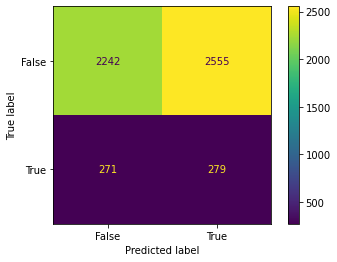

In [26]:
helper.pred_model(clf_dummy, X_train_trans_r, X_test_trans, y_train_r, y_test)

+ .47
+ False: .89, .47
+ True: .1, .51

## Logistic Regression
### Standard Scaler

In [27]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", ss, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

# Over/undersampling
X_train_trans_r, y_train_r = sme.fit_resample(X_train_trans, y_train)

In [31]:
logreg_ss = LogisticRegression(max_iter=400, random_state=42)

In [32]:
repeats = range(5)
logreg_ss_train = []
for r in repeats:
	# evaluate using a given number of repeats
	scores_train = helper.evaluate_model(logreg_ss, X_train_trans_r, y_train_r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, np.mean(scores_train), sem(scores_train)))
	# store
	logreg_ss_train.append(scores_train)

>0 mean=0.8185 se=0.002
>1 mean=0.8185 se=0.002
>2 mean=0.8185 se=0.002
>3 mean=0.8185 se=0.002
>4 mean=0.8185 se=0.002


              precision    recall  f1-score   support

       False       0.96      0.69      0.80      4797
        True       0.21      0.73      0.33       550

    accuracy                           0.70      5347
   macro avg       0.59      0.71      0.57      5347
weighted avg       0.88      0.70      0.76      5347

[[3330 1467]
 [ 150  400]]


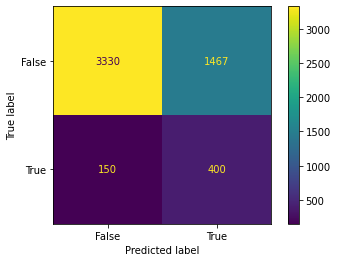

In [46]:
m_logreg_ss, y_pred = helper.pred_model(logreg_ss, X_train_trans_r, X_test_trans, y_train_r, y_test)

The recall is 73% , the accuracy is 70%. Though, the precision is low with 22%. By adjusting the threshold to 0.1 we achieve a high recall (97%) but the accuracy decreases significantly to 32%.

In [48]:
# Classification report
y_probs = m_logreg_ss.predict_proba(X_test_trans)[:, 1]

y_pred = y_probs > 0.1
print(f"--- CLASSIFICATION REPORT {'-'*10}")
print(classification_report(y_test,y_pred))
print(f"--- CONFUSION MATRIX {'-'*10}")
print(confusion_matrix(y_test,y_pred))

--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

       False       0.99      0.24      0.39      4797
        True       0.13      0.97      0.23       550

    accuracy                           0.32      5347
   macro avg       0.56      0.61      0.31      5347
weighted avg       0.90      0.32      0.37      5347

--- CONFUSION MATRIX ----------
[[1161 3636]
 [  16  534]]


### MinMax Scaling

Let's see if we achieve other - even better - results with the MinMaxScaler.

In [49]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", mms, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

# Oversmapling and Undersampling
X_train_trans_r, y_train_r = sme.fit_resample(X_train_trans, y_train)

In [ ]:
# Calculate the LogisticRegression
logreg = LogisticRegression(max_iter=400)
logreg_pipe = make_pipeline(sme, logreg)

In [ ]:
repeats = range(5)
logreg_train = []
for r in repeats:
	# evaluate using a given number of repeats
	scores_train = helper.evaluate_model(logreg, X_train_trans_r, y_train_r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, np.mean(scores_train), sem(scores_train)))
	# store
	logreg_train.append(scores_train)

              precision    recall  f1-score   support

       False       0.96      0.69      0.80      4797
        True       0.21      0.73      0.33       550

    accuracy                           0.70      5347
   macro avg       0.59      0.71      0.57      5347
weighted avg       0.88      0.70      0.76      5347

[[3330 1467]
 [ 150  400]]


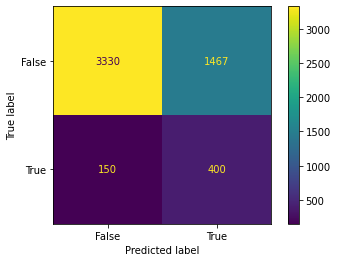

In [54]:
m_logreg_mm, y_pred = helper.pred_model(logreg, X_train_trans_r, X_test_trans, y_train_r, y_test)

The Logistic Regression model with MinMax scaled data is identical to the one with standard scaled data (recall = 73%). The same is true, when we adjust the threshold to achieve a higher recall. Overall, there is no difference between using the Standard Scaler and the MinMax Scaler.

In [56]:
# Classification report
y_probs = m_logreg_mm.predict_proba(X_test_trans)[:, 1]

y_pred = y_probs > 0.1
print(f"--- CLASSIFICATION REPORT {'-'*10}")
print(classification_report(y_test,y_pred))
print(f"--- CONFUSION MATRIX {'-'*10}")
print(confusion_matrix(y_test,y_pred))

--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

       False       0.99      0.24      0.39      4797
        True       0.13      0.97      0.23       550

    accuracy                           0.32      5347
   macro avg       0.56      0.61      0.31      5347
weighted avg       0.90      0.32      0.37      5347

--- CONFUSION MATRIX ----------
[[1161 3636]
 [  16  534]]


## K Nearest Neighbor (KNN)

### Data Transformation

KNN compares observations based on a similarity measure. Therefore, we need to scale numerical features and use one-hot-encoding for our categorical features. Using one-hot encoding creates a sparse matrix and reduces KNN efficiency. 

In [57]:
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()

# Define transformer
transformer = ColumnTransformer([
    ("scale", ss, num_cols),
    ("encode", onehot, make_column_selector(dtype_include="category")),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

X_train_trans_r, y_train_r = sme.fit_resample(X_train_trans, y_train)

We will use the manhattan distance for similarity as our data is sparse.

In [61]:
# Define Classifier
knn = KNeighborsClassifier(p=1, n_jobs=-1)
knn_pipe = make_pipeline(sme, knn)

In [66]:
scores_knn_train = helper.evaluate_model(knn, X_train_trans_r, y_train_r)
np.mean(scores_knn_train)

0.9789329018267479

              precision    recall  f1-score   support

       False       0.94      0.73      0.82      4797
        True       0.20      0.59      0.30       550

    accuracy                           0.72      5347
   macro avg       0.57      0.66      0.56      5347
weighted avg       0.86      0.72      0.77      5347

[[3510 1287]
 [ 227  323]]


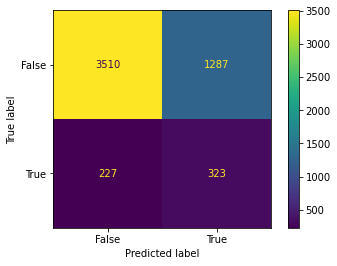

In [67]:
m_knn, y_pred = helper.pred_model(knn_pipe, X_train_trans_r, X_test_trans, y_train_r, y_test)

The recall is 59% and the accuracy is 72%. This looks promising. Let's run a randomized grid search to adjust the hyperparameters of the model.

In [73]:
params_grid = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_best_score, knn_best_params = helper.rs_model(knn, X_train_trans_r, y_train_r , params_grid)

/Users/Nicole/Documents/Data_Science/neuefische/projects/Capstone/stroke/Stroke-Outcome/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 16 is smaller than n_iter=500. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Best Score: 0.9921019342576233
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'euclidean'}


Best Score: 0.9921019342576233
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'euclidean'}

In [75]:
knn_best = KNeighborsClassifier(weights = 'distance', n_neighbors = 3, metric = 'euclidean', n_jobs=-1)
scores_knn_best_train = helper.evaluate_model(knn_best, X_train_trans_r, y_train_r)
np.mean(scores_knn_best_train)

0.9920005063597687

              precision    recall  f1-score   support

       False       0.94      0.74      0.83      4797
        True       0.20      0.55      0.29       550

    accuracy                           0.72      5347
   macro avg       0.57      0.65      0.56      5347
weighted avg       0.86      0.72      0.77      5347

[[3565 1232]
 [ 247  303]]


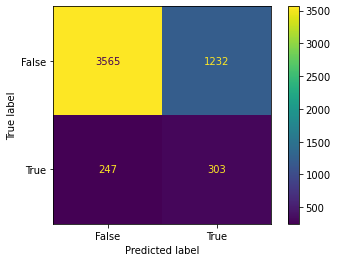

In [76]:
m_knn_best, y_pred = helper.pred_model(knn_best, X_train_trans_r, X_test_trans, y_train_r, y_test)

Recall of this KNN model is 55% and accuracy is 72%

## Decision Tree

For Decision Trees numerical data doesn't need to be scaled. Categorical data needs to be encoded. As One-Hot-Encoding leads to sparse data and decreases the performance of decision trees, we encode the categories numerically.

In [77]:
# Encode categorical features (with more than two classes)
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX','RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

In [78]:
# Define Classifier
dtree = DecisionTreeClassifier(random_state=42)
dtree_pipe = make_pipeline(sme, dtree)

In [80]:
scores_dtree = helper.evaluate_model(dtree_pipe, X_train_trans, y_train)
print(f'Average Score: {round(np.mean(scores_dtree),3)} with an Standard Error of {round(sem(scores_dtree), 4)}')

Average Score: 0.441 with an Standard Error of 0.0056


              precision    recall  f1-score   support

       False       0.92      0.78      0.84      4797
        True       0.18      0.44      0.26       550

    accuracy                           0.74      5347
   macro avg       0.55      0.61      0.55      5347
weighted avg       0.85      0.74      0.78      5347

[[3729 1068]
 [ 309  241]]


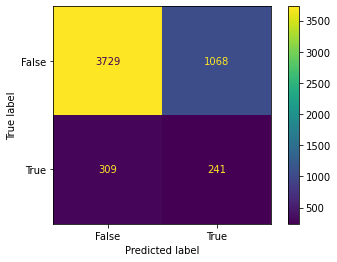

In [81]:
m_dtree, y_pred = helper.pred_model(dtree_pipe, X_train_trans, X_test_trans, y_train, y_test)

The decision tree model has a recall of 44% and an accuracy of 74%.

#### With imbalanced data

Here we try using the imbalanced data and let the function of decisiontree() balance the data by implementing `class_weight`, instead of SMOTEENN.

In [82]:
dtree_w = DecisionTreeClassifier(random_state=42, class_weight= 'balanced')

In [84]:
scores_dtree_w = helper.evaluate_model(dtree_w, X_train_trans, y_train)
print(f'Average Score: {round(np.mean(scores_dtree_w),3)} with an Standard Error of {round(sem(scores_dtree_w), 4)}')

Average Score: 0.21 with an Standard Error of 0.005


              precision    recall  f1-score   support

       False       0.91      0.89      0.90      4797
        True       0.18      0.20      0.19       550

    accuracy                           0.82      5347
   macro avg       0.54      0.55      0.54      5347
weighted avg       0.83      0.82      0.83      5347

[[4276  521]
 [ 439  111]]


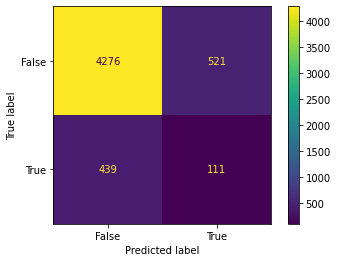

In [85]:
m_dtree_w, y_pred = helper.pred_model(dtree_w, X_train_trans, X_test_trans, y_train, y_test)

Recall has actually dreceased to 20%, accuracy increased to 82%.

## Random Forest
For Random Forests we use the same data scaling and encoding as for decision trees.

In [87]:
# Encode categorical features (with more than two classes)
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

In [88]:
# Define Classifier
rf = RandomForestClassifier(random_state = 42)
# Define Classifier
rf_pipe = make_pipeline(sme, rf)

In [89]:
scores_rf = helper.evaluate_model(rf_pipe, X_train_trans, y_train)
print(f'Average Score: {round(np.mean(scores_rf),3)} with an Standard Error of {round(sem(scores_rf), 4)}')

Average Score: 0.46 with an Standard Error of 0.0062


              precision    recall  f1-score   support

       False       0.93      0.80      0.86      4797
        True       0.21      0.47      0.29       550

    accuracy                           0.77      5347
   macro avg       0.57      0.63      0.58      5347
weighted avg       0.86      0.77      0.80      5347

[[3847  950]
 [ 293  257]]


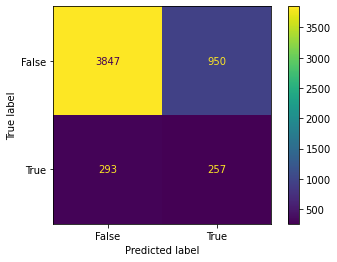

In [90]:
m_rf, y_pred = helper.pred_model(rf_pipe, X_train_trans, X_test_trans, y_train, y_test)

Recall is 47% and accuracy is 77% - of the RandomForest. 

#### With imbalanced 

As conducted with Decision Tree, we will now try using the imbalanced data and let randomforest balance the weights of the groups.

In [91]:
rf_w = RandomForestClassifier(random_state = 42, class_weight= 'balanced')

Average Score: 0.107 with an Standard Error of 0.0034
              precision    recall  f1-score   support

       False       0.90      0.96      0.93      4797
        True       0.22      0.11      0.15       550

    accuracy                           0.87      5347
   macro avg       0.56      0.53      0.54      5347
weighted avg       0.83      0.87      0.85      5347

[[4583  214]
 [ 488   62]]


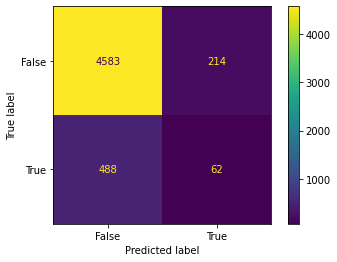

In [92]:
scores_rf_w = helper.evaluate_model(rf_w, X_train_trans, y_train)
print(f'Average Score: {round(np.mean(scores_rf_w),3)} with an Standard Error of {round(sem(scores_rf_w), 4)}')

m_rf_w, y_pred = helper.pred_model(rf_w, X_train_trans, X_test_trans, y_train, y_test)

Recall has decreased down to 11%, accuracy has increased to 87%.

## Extra Tree

Still working with trees, we keep the same data transformation:

In [93]:
# Encode categorical features (with more than two classes)
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

In [94]:
etree = ExtraTreesClassifier(random_state=42)
etree_pipe = make_pipeline(sme, etree)

In [95]:
scores_etree = helper.evaluate_model(etree_pipe, X_train_trans, y_train)
print(f'Average Score: {round(np.mean(scores_etree),3)} with an Standard Error of {round(sem(scores_etree), 4)}')

Average Score: 0.417 with an Standard Error of 0.0057


              precision    recall  f1-score   support

       False       0.93      0.82      0.87      4797
        True       0.22      0.46      0.30       550

    accuracy                           0.78      5347
   macro avg       0.58      0.64      0.58      5347
weighted avg       0.86      0.78      0.81      5347

[[3921  876]
 [ 299  251]]


(Pipeline(steps=[('smoteenn', SMOTEENN(random_state=42)),
                 ('extratreesclassifier',
                  ExtraTreesClassifier(random_state=42))]),
 array([ True, False,  True, ..., False, False, False]))

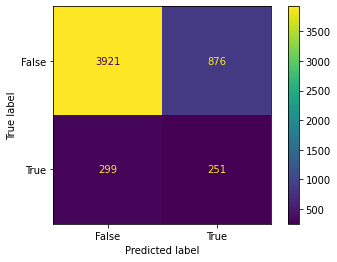

In [96]:
helper.pred_model(etree_pipe, X_train_trans, X_test_trans, y_train, y_test)

The recall of the Extra Tree is 46% and accuracy is 78%. 

#### With imbalanced 

As conducted with Decision Tree and Random Forest, we will now try using the imbalanced data and let randomforest balance the weights of the groups.

In [98]:
etree_w = ExtraTreesClassifier(random_state=42, class_weight = 'balanced')
etree_pipe_w = make_pipeline(sme, etree_w)

Average Score: 0.414 with an Standard Error of 0.0058
              precision    recall  f1-score   support

       False       0.93      0.82      0.87      4797
        True       0.22      0.45      0.30       550

    accuracy                           0.78      5347
   macro avg       0.57      0.63      0.58      5347
weighted avg       0.86      0.78      0.81      5347

[[3922  875]
 [ 303  247]]


(Pipeline(steps=[('smoteenn', SMOTEENN(random_state=42)),
                 ('extratreesclassifier',
                  ExtraTreesClassifier(class_weight='balanced',
                                       random_state=42))]),
 array([ True, False,  True, ..., False, False, False]))

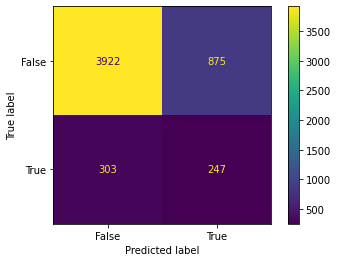

In [99]:
scores_etree_w = helper.evaluate_model(etree_pipe_w, X_train_trans, y_train)
print(f'Average Score: {round(np.mean(scores_etree_w),3)} with an Standard Error of {round(sem(scores_etree_w), 4)}')
helper.pred_model(etree_pipe_w, X_train_trans, X_test_trans, y_train, y_test)

The Extra Tree with the imbalanced data acheives a recall of 45% and an accuracy of 78% - and so it performed similar to the Extra Tree with SMOTEENN transformed data.

### XGBoost
As XGBoost is working with trees, we use the same data transformation where we encode categories numerically.

In [100]:
# Encode categorical features 
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

In [101]:
# Define Classifier
xgb = XGBClassifier(random_state = 42)
xgb_pipe = make_pipeline(sme, xgb)

In [102]:
scores_xgb = helper.evaluate_model(xgb_pipe, X_train_trans, y_train)
print(f'Average Score: {round(np.mean(scores_xgb),3)} with an Standard Error of {round(sem(scores_xgb), 4)}')

Average Score: 0.499 with an Standard Error of 0.0063


/Users/Nicole/Documents/Data_Science/neuefische/projects/Capstone/stroke/Stroke-Outcome/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[15:02:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

       False       0.93      0.76      0.83      4797
        True       0.19      0.48      0.27       550

    accuracy         

(Pipeline(steps=[('smoteenn', SMOTEENN(random_state=42)),
                 ('xgbclassifier',
                  XGBClassifier(base_score=0.5, booster='gbtree',
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints='',
                                learning_rate=0.300000012, max_delta_step=0,
                                max_depth=6, min_child_weight=1, missing=nan,
                                monotone_constraints='()', n_estimators=100,
                                n_jobs=4, num_parallel_tree=1, random_state=42,
                                reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                subsample=1, tree_method='exact',
                                validate_parameters=1, verbosity=None))]),
 array([ True, False, False, ..., False, False, 

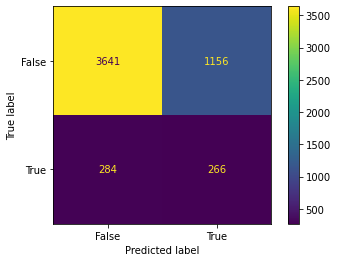

In [103]:
helper.pred_model(xgb_pipe, X_train_trans, X_test_trans, y_train, y_test)

The recall of the XGBoost model was 48% and had an accuracy of 73%.

## Support Vector Machines

In [104]:
# Encode categorical features 
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

In [105]:
# Define Classifier
svc = SVC(random_state = 42)
svc_pipe = make_pipeline(sme, svc)

In [106]:
scores_svc = helper.evaluate_model(svc_pipe, X_train_trans, y_train)
print(f'Average Score: {round(np.mean(scores_svc),3)} with an Standard Error of {round(sem(scores_svc), 4)}')

Average Score: 0.752 with an Standard Error of 0.0056


              precision    recall  f1-score   support

       False       0.94      0.47      0.63      4797
        True       0.14      0.73      0.23       550

    accuracy                           0.50      5347
   macro avg       0.54      0.60      0.43      5347
weighted avg       0.86      0.50      0.59      5347

[[2278 2519]
 [ 151  399]]


(Pipeline(steps=[('smoteenn', SMOTEENN(random_state=42)),
                 ('svc', SVC(random_state=42))]),
 array([ True,  True,  True, ...,  True, False,  True]))

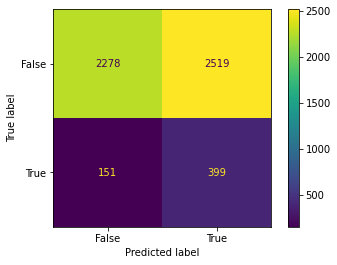

In [107]:
helper.pred_model(svc_pipe, X_train_trans, X_test_trans, y_train, y_test)

The Support Vector Machine achieved a high recall of 73%, though the accuracy was rather low with 50%.

## Summary

Model | Accuracy | Precision (1) | Recall (1) | Precision (0) | Recall (0)
:--- | ---: | ---: | ---: | ---: | ---: 
Dummy Classifier | 0.50 | 0.81 | 0.5 | 0.19 | 0.50
**Logistic Regression (SS)** | 0.70 | 0.33 | 0.73 | 0.96 | 0.69
Logistic Regression (SS, threshold <0.1) | 0.32 | 0.14 | 0.97 | 0.99 | 0.24
Logistic Regression (MMS) | 0.70 | 0.33 | 0.73 | 0.96 | 0.69
Logistic Regression (MMS, threshold <0.1) | 0.32 | 0.14 | 0.97 | 0.99 | 0.24
KNearest Neighbor | 0.72 | 0.20 | 0.59 | 0.94 | 0.73
Decision Tree | 0.74 | 0.18 | 0.44 | 0.92 | 0.78
Decision Tree (imbalanced) | 0.82 | 0.18 | 0.20 | 0.91 | 0.89
Random Forest | 0.77 | 0.21 | 0.47 | 0.93 | 0.80
Random Forest (imbalanced) | 0.87 | 0.22 | 0.11 | 0.90 | 0.96
Extra Tree | 0.78 | 0.22 | 0.46 | 0.93 | 0.82
Extra Tree (imbalanced) | 0.78 | 0.22 | 0.45 | 0.93 | 0.82
XGBoost | 0.73 | 0.19 | 0.48 | 0.93 | 0.76
Support Vector Machine | 0.50 | 0.14 | 0.73 | 0.94 | 0.47

In conclusion, Logistic Regression was the best model to predict the short term outcome of stroke patients.